# Train CycleGAN Notebook

This notebook realizes a quick training of a CycleGAN (stabilityAI/sd-turbo) using merlin's BosonSampler on day and night car images (small part of dataset BDD-100k). The CycleGAN was pretrained on the whole dataset and the idea was then to add a BosonSampler, before the decoder, and to train only the decoder. This method has shown some results on a challenge organized by BMW and Airbus to turn driving in the day images into driving in the night images. The original architecture was based on this github https://github.com/GaParmar/img2img-turbo. We did a first training without any quantum layers and then a second one, starting from the pretained weights and adding a quantum layer. The notebook here is a small reproduction of the second training, with a dataset of only 200 images. The dataset is not directly in the MerLin repository, however you can specify where to download it with the _args.dataset_folder_ variable. It goes the same for the outputs of the model with the _args.output_dir_ variable. Be careful: it is necessary to have access to a cuda device to run this model. *To run this model you'll need to install the requirements present in the img2img-turbo-annotations folder.*

In [1]:
import torch
import gc
import copy
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import lpips
from accelerate import Accelerator
from accelerate.utils import set_seed
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.optimization import get_scheduler
from peft.utils import get_peft_model_state_dict
from cleanfid.fid import get_folder_features, build_feature_extractor, frechet_distance
import vision_aided_loss
from img2img_turbo_annotations.src_quantum.model import make_1step_sched
from img2img_turbo_annotations.src_quantum.cyclegan_turbo import CycleGAN_Turbo, VAE_encode, VAE_decode, initialize_unet, initialize_vae
from img2img_turbo_annotations.src_quantum.my_utils.training_utils import UnpairedDataset, build_transform, parse_args_training, \
    UnpairedDataset_Quantum, get_next_id, read_from_emb16, image_fail, read_from_emb32, load_small_dataset
from img2img_turbo_annotations.src_quantum.my_utils.dino_struct import DinoStructureLoss
import h5py
import torch.nn.init as init
import pandas as pd
from img2img_turbo_annotations.src_quantum.BosonSampler import BosonSampler
import time
import shutil
import argparse
import os
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt


### Adjust key parameters and variables

In [2]:
args = parse_args_training()


### Loading Boson Sampler

In [3]:
if args.quantum_dynamic:                                                                                                    
    # Set the random seeds
    torch.manual_seed(args.seed)
    print("boson sampler dims", (args.quantum_processes, ) + args.quantum_dims)
    boson_sampler = BosonSampler((args.quantum_processes, ) + args.quantum_dims)
    print("-- Boson Sampler defined --")

boson sampler dims (2, 4, 16, 16)
time to load model 4.525424480438232
-- Boson Sampler defined --


In [4]:
 accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps)


# set up id and name of experiment
exp_id = get_next_id()
os.makedirs(args.output_dir, exist_ok=True)
args.exp_id = exp_id
if accelerator.is_main_process:
    os.makedirs(os.path.join(args.output_dir, "checkpoints"), exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained("stabilityai/sd-turbo", subfolder="tokenizer", revision=args.revision,
                                          use_fast=False, )
noise_scheduler_1step = make_1step_sched()
text_encoder = CLIPTextModel.from_pretrained("stabilityai/sd-turbo", subfolder="text_encoder").cuda()

weight_dtype = torch.float32

text_encoder.to(accelerator.device, dtype=weight_dtype)
text_encoder.requires_grad_(False)
if args.gan_disc_type == "vagan_clip":
    net_disc_a = vision_aided_loss.Discriminator(cv_type='clip', loss_type=args.gan_loss_type, device="cuda")
    net_disc_a.cv_ensemble.requires_grad_(False)  # Freeze feature extractor
    net_disc_b = vision_aided_loss.Discriminator(cv_type='clip', loss_type=args.gan_loss_type, device="cuda")
    net_disc_b.cv_ensemble.requires_grad_(False)  # Freeze feature extractor

crit_cycle, crit_idt = torch.nn.L1Loss(), torch.nn.L1Loss()

/home/ubuntu/miniconda3/envs/BMW_challenge/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Load pretrained weights

In [5]:

if args.quantum_dynamic or args.cl_comp:
    print("- building the model")
    unet, l_modules_unet_encoder, l_modules_unet_decoder, l_modules_unet_others = initialize_unet(
        args.lora_rank_unet, return_lora_module_names=True)
    vae_a2b, vae_lora_target_modules = initialize_vae(args.lora_rank_vae, return_lora_module_names=True,
                                                      dynamic=args.quantum_dynamic)
    print("-- Loading from pretrained weights for quantum training")
    
    print(f"Defining cyclegan_d on process {accelerator.process_index}")
    model_path = hf_hub_download(repo_id="quandelagl/img-to-img-turbo-pretrained", filename=args.pretrained_model_path)
    cyclegan_d = CycleGAN_Turbo(accelerator=accelerator, pretrained_path=model_path) #pretrained_path=args.quantum_start_path,
    print("--- CycleGAN defined")
    vae_enc = cyclegan_d.vae_enc
    vae_dec = cyclegan_d.vae_dec
    vae_a2b = cyclegan_d.vae
    vae_b2a = cyclegan_d.vae_b2a
    unet = cyclegan_d.unet


    unet.conv_in.requires_grad_(True)

    weight_dtype = torch.float32
    """vae_a2b.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    vae_b2a = copy.deepcopy(vae_a2b)"""

    # freeze the VAE enc and detach it from the gradient
    vae_enc.requires_grad_(False)                                                                                                                                                                                                                   
    # train the post_quant_conv layer at the                                                                                
    vae_a2b.post_quant_conv.requires_grad_(True)                                                                         
    vae_b2a.post_quant_conv.requires_grad_(True)                                                                              
# get the trainable parameters (vae_a2b.encoder and vae_b2a.encoder should have 0 trainable parameters)                 
    params_gen = cyclegan_d.get_traininable_params(unet, vae_a2b, vae_b2a, boson_sampler, dynamic=True, quantum_training=True)                                                                                                                      
    print(f"-- {vae_a2b.encoder.conv_in.__class__.__name__}: requires_grad={vae_a2b.encoder.conv_in.weight.requires_grad_}")    
    


    


    # CLASSICAL NETWORKS with no initialization
else:
    print("--- Classical CycleGAN training ---")
    print("- building the model")
    unet, l_modules_unet_encoder, l_modules_unet_decoder, l_modules_unet_others = initialize_unet(
        args.lora_rank_unet, return_lora_module_names=True)
    vae_a2b, vae_lora_target_modules = initialize_vae(args.lora_rank_vae, return_lora_module_names=True,
                                                      dynamic=args.quantum_dynamic)
    vae_a2b.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    unet.conv_in.requires_grad_(True)
    vae_b2a = copy.deepcopy(vae_a2b)
    params_gen = CycleGAN_Turbo.get_traininable_params(unet, vae_a2b, vae_b2a, boson_sampler)
    vae_enc = VAE_encode(vae_a2b, vae_b2a=vae_b2a)
    vae_dec = VAE_decode(vae_a2b, vae_b2a=vae_b2a)

    print(
        f"-- {vae_a2b.encoder.conv_in.__class__.__name__}: requires_grad={vae_a2b.encoder.conv_in.weight.requires_grad_}")
    print(
        f"-- For vae_enc = {sum(p.numel() for p in vae_enc.parameters() if p.requires_grad)}, - a2b = {sum(p.numel() for p in vae_a2b.encoder.parameters() if p.requires_grad)} and -b2a = {sum(p.numel() for p in vae_b2a.encoder.parameters() if p.requires_grad)}")
    print(f"-- For unet = {sum(p.numel() for p in unet.parameters() if p.requires_grad)}")
    print(
        f"-- For unet.conv_in = {sum(p.numel() for p in unet.conv_in.parameters() if p.requires_grad)} - unet.conv_out = {sum(p.numel() for p in unet.conv_out.parameters() if p.requires_grad)} ")
print(f"-- TOTAL parameters = {sum(p.numel() for p in unet.parameters())+sum(p.numel() for p in vae_a2b.parameters())+sum(p.numel() for p in vae_b2a.parameters())}")
print(
    f"-- TOTAL trainable parameters = {sum(p.numel() for p in unet.parameters() if p.requires_grad) + sum(p.numel() for p in vae_a2b.parameters() if p.requires_grad) + sum(p.numel() for p in vae_b2a.parameters() if p.requires_grad)}")
if args.enable_xformers_memory_efficient_attention:                                                                         
    unet.enable_xformers_memory_efficient_attention()

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
    

- building the model
-----> Number of parameters in UNet: 865910724
-- Loading from pretrained weights for quantum training
Defining cyclegan_d on process 0
-- Loading from pretrained path not None --
--load_ckpt_from_state_dict--
--- CycleGAN defined
-- Conv2d: requires_grad=<built-in method requires_grad_ of Parameter object at 0x71aad43a4ea0>
-- TOTAL parameters = 1165770722
-- TOTAL trainable parameters = 129794664


### Load and prepare dataset

In [6]:
optimizer_gen = torch.optim.AdamW(params_gen, lr=args.learning_rate, betas=(args.adam_beta1, args.adam_beta2),
                                  weight_decay=args.adam_weight_decay, eps=args.adam_epsilon, )

params_disc = list(net_disc_a.parameters()) + list(net_disc_b.parameters())
optimizer_disc = torch.optim.AdamW(params_disc, lr=args.learning_rate, betas=(args.adam_beta1, args.adam_beta2),
                                   weight_decay=args.adam_weight_decay, eps=args.adam_epsilon, )

_ = load_small_dataset("quandelagl/small-bdd-100k", args.dataset_folder)
print(args.dataset_folder)
dataset_train = UnpairedDataset(dataset_folder=args.dataset_folder, image_prep=args.train_img_prep,
                                split="train", tokenizer=tokenizer, part = args.training_images)
#here, we could lower the number of images used
print(f"- Dataset loaded")

print(f"--> Length of dataset_train = {len(dataset_train)}")
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=args.train_batch_size, shuffle=True,
                                               num_workers=args.dataloader_num_workers)
print("- Data loaded")
T_val = build_transform(args.val_img_prep)
fixed_caption_src = dataset_train.fixed_caption_src
fixed_caption_tgt = dataset_train.fixed_caption_tgt
l_images_src_test = []
for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
    l_images_src_test.extend(glob(os.path.join(args.dataset_folder, "test_a", ext)))
l_images_src_test_2 = [el for el in l_images_src_test if os.path.basename(el)]# not in list_failures]
l_images_src_test = l_images_src_test_2
l_images_tgt_test = []
for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
    l_images_tgt_test.extend(glob(os.path.join(args.dataset_folder, "test_b", ext)))

l_images_src_test, l_images_tgt_test = sorted(l_images_src_test), sorted(l_images_tgt_test)
#l_images_src_test, l_images_tgt_test = l_images_src_test[:100], l_images_tgt_test[:100]
print(f"- FOR TEST PURPOSE: working with {len(l_images_src_test)} and {len(l_images_tgt_test)}")


loading small dataset


/home/ubuntu/miniconda3/envs/BMW_challenge/lib/python3.10/site-packages/torch/optim/adamw.py:50: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)
Saving test_b: 100%|███████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 504.69it/s]

img2img_turbo_annotations/dataset
Dataset folder = img2img_turbo_annotations/dataset
- Dataset loaded
--> Length of dataset_train = 400
- Data loaded
- FOR TEST PURPOSE: working with 80 and 80


In [22]:
if accelerator.is_main_process:
    feat_model = build_feature_extractor("clean", "cuda", use_dataparallel=False)
    """
    FID reference statistics for A -> B translation
    """
    output_dir_ref = os.path.join(args.output_dir, "fid_reference_a2b")
    os.makedirs(output_dir_ref, exist_ok=True)
    # transform all images according to the validation transform and save them
    for _path in tqdm(l_images_tgt_test):
        _img = T_val(Image.open(_path).convert("RGB"))
        outf = os.path.join(output_dir_ref, os.path.basename(_path)).replace(".jpg", ".png")
        if not os.path.exists(outf):
            _img.save(outf)
    # compute the features for the reference images
    ref_features = get_folder_features(output_dir_ref, model=feat_model, num_workers=0, num=None,
                                       shuffle=False, seed=0, batch_size=8, device=torch.device("cuda"),
                                       mode="clean", custom_fn_resize=None, description="", verbose=True,
                                       custom_image_tranform=None)
    a2b_ref_mu, a2b_ref_sigma = np.mean(ref_features, axis=0), np.cov(ref_features, rowvar=False)
    """
    FID reference statistics for B -> A translation
    """
    # transform all images according to the validation transform and save them
    output_dir_ref = os.path.join(args.output_dir, "fid_reference_b2a")
    os.makedirs(output_dir_ref, exist_ok=True)
    for _path in tqdm(l_images_src_test):
        _img = T_val(Image.open(_path).convert("RGB"))
        outf = os.path.join(output_dir_ref, os.path.basename(_path)).replace(".jpg", ".png")
        if not os.path.exists(outf):
            _img.save(outf)
    # compute the features for the reference images
    ref_features = get_folder_features(output_dir_ref, model=feat_model, num_workers=0, num=None,
                                       shuffle=False, seed=0, batch_size=8, device=torch.device("cuda"),
                                       mode="clean", custom_fn_resize=None, description="", verbose=True,
                                       custom_image_tranform=None)
    b2a_ref_mu, b2a_ref_sigma = np.mean(ref_features, axis=0), np.cov(ref_features, rowvar=False)

  0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder img2img_turbo_annotations/outputs/fid_reference_a2b


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.93it/s]


  0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder img2img_turbo_annotations/outputs/fid_reference_b2a


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.32it/s]


In [8]:
print("- Defining the scheduler for generators + discriminator")
lr_scheduler_gen = get_scheduler(args.lr_scheduler, optimizer=optimizer_gen,
                                 num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
                                 num_training_steps=args.max_train_steps * accelerator.num_processes,
                                 num_cycles=args.lr_num_cycles, power=args.lr_power)
lr_scheduler_disc = get_scheduler(args.lr_scheduler, optimizer=optimizer_disc,
                                  num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
                                  num_training_steps=args.max_train_steps * accelerator.num_processes,
                                  num_cycles=args.lr_num_cycles, power=args.lr_power)

net_lpips = lpips.LPIPS(net='vgg')
net_lpips.cuda()
net_lpips.requires_grad_(False)

/home/ubuntu/miniconda3/envs/BMW_challenge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/BMW_challenge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- Defining the scheduler for generators + discriminator
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/miniconda3/envs/BMW_challenge/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): vgg16(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, 

### Defining the text embeddings

In [9]:

fixed_a2b_tokens = \
tokenizer(fixed_caption_tgt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True,
          return_tensors="pt").input_ids[0]
fixed_a2b_emb_base = text_encoder(fixed_a2b_tokens.cuda().unsqueeze(0))[0].detach()
fixed_b2a_tokens = \
tokenizer(fixed_caption_src, max_length=tokenizer.model_max_length, padding="max_length", truncation=True,
          return_tensors="pt").input_ids[0]
fixed_b2a_emb_base = text_encoder(fixed_b2a_tokens.cuda().unsqueeze(0))[0].detach()
del text_encoder, tokenizer  # free up some memory

unet, vae_enc, vae_dec, net_disc_a, net_disc_b = accelerator.prepare(unet, vae_enc, vae_dec, net_disc_a, net_disc_b)    
net_lpips, optimizer_gen, optimizer_disc, train_dataloader, lr_scheduler_gen, lr_scheduler_disc = accelerator.prepare(
    net_lpips, optimizer_gen, optimizer_disc, train_dataloader, lr_scheduler_gen, lr_scheduler_disc
)

In [13]:
def disable_attention(net):
    for name, module in net.named_modules():
        if "attn" in name:
            module.fused_attn = False

def forward_cycle(img, direction, text_emb, q_emb=None):
    return cyclegan_d.forward_with_networks_dynamic(
        img, direction, vae_enc, unet, vae_dec, noise_scheduler_1step,
        timesteps, text_emb, q_emb=q_emb, bs=boson_sampler,
        device=accelerator.device, accelerator=accelerator
    )

def compute_gan_loss(fake_a, fake_b):
    loss_a = net_disc_a(fake_b, for_G=True).mean() * args.lambda_gan
    loss_b = net_disc_b(fake_a, for_G=True).mean() * args.lambda_gan
    return loss_a + loss_b

def compute_identity_loss(img_a, img_b, q_emb_a, q_emb_b, fixed_a2b_emb, fixed_b2a_emb):
    idt_a = forward_cycle(img_b, "a2b", fixed_a2b_emb, q_emb=q_emb_b)
    idt_b = forward_cycle(img_a, "b2a", fixed_b2a_emb, q_emb=q_emb_a)

    loss_a = crit_idt(idt_a, img_b) * args.lambda_idt
    loss_a += net_lpips(idt_a, img_b).mean() * args.lambda_idt_lpips

    loss_b = crit_idt(idt_b, img_a) * args.lambda_idt
    loss_b += net_lpips(idt_b, img_a).mean() * args.lambda_idt_lpips

    return loss_a + loss_b, idt_a, idt_b

def compute_discriminator_loss(real_a, real_b, fake_a, fake_b):
    loss_real = (
        net_disc_a(real_b, for_real=True).mean() +
        net_disc_b(real_a, for_real=True).mean()
    ) * 0.5 * args.lambda_gan

    loss_fake = (
        net_disc_a(fake_b.detach(), for_real=False).mean() +
        net_disc_b(fake_a.detach(), for_real=False).mean()
    ) * 0.5 * args.lambda_gan

    return loss_real + loss_fake, loss_real, loss_fake

def has_nan(*tensors):
    return any(torch.isnan(t).any() for t in tensors)

In [14]:
def validate_direction(direction, image_list, ref_mu, ref_sigma, 
                       fixed_emb, vae_enc, unet, vae_dec,
                       feat_model, global_step, args, net_dino, device="cuda"):
    assert direction in ["a2b", "b2a"]
    save_dir = os.path.join(args.output_dir, f"fid-{global_step}/samples_{direction}")
    os.makedirs(save_dir, exist_ok=True)

    dino_scores = []
    _timesteps = torch.tensor([noise_scheduler_1step.config.num_train_timesteps - 1], device=device).long()

    for idx, img_path in enumerate(tqdm(image_list, desc=f"Validation {direction}")):
        if args.validation_num_images > 0 and idx >= args.validation_num_images:
            break

        input_img = T_val(Image.open(img_path).convert("RGB"))
        tensor_img = transforms.ToTensor()(input_img)
        tensor_img = transforms.Normalize([0.5], [0.5])(tensor_img).unsqueeze(0).to(device)

        with torch.no_grad():
            if args.quantum_dynamic:
                fake_out, _ = cyclegan_d.forward_with_networks_dynamic(
                    tensor_img, direction,
                    vae_enc, unet, vae_dec,
                    noise_scheduler_1step, _timesteps,
                    fixed_emb[0:1],
                    bs=boson_sampler,
                    device=device
                )
            else:
                fake_out = CycleGAN_Turbo.forward_with_networks(
                    tensor_img, direction,
                    vae_enc, unet, vae_dec,
                    noise_scheduler_1step, _timesteps,
                    fixed_emb[0:1]
                )

        fake_pil = transforms.ToPILImage()(fake_out[0] * 0.5 + 0.5)
        fake_pil.save(os.path.join(save_dir, f"{idx}.png"))

        a = net_dino.preprocess(input_img).unsqueeze(0).to(device)
        b = net_dino.preprocess(fake_pil).unsqueeze(0).to(device)
        dino_ssim = net_dino.calculate_global_ssim_loss(a, b).item()
        dino_scores.append(dino_ssim)

    dino_mean = np.mean(dino_scores)

    gen_features = get_folder_features(
        save_dir, model=feat_model, num_workers=0, num=None,
        shuffle=False, seed=0, batch_size=8,
        device=torch.device(device), mode="clean",
        custom_fn_resize=None, description="", verbose=True
    )
    mu, sigma = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)
    fid = frechet_distance(ref_mu, ref_sigma, mu, sigma)

    shutil.rmtree(save_dir)
    return fid, dino_mean


### Training the model with BosonSampler

In [64]:
if accelerator.is_main_process:
    config = dict(vars(args))
    config["run_name"] = f"qCycleGAN-{args.exp_id}"

disable_attention(net_disc_a)
disable_attention(net_disc_b)
first_epoch = 0
global_step = 0
progress_bar = tqdm(range(0, args.max_train_steps), initial=global_step, desc="Steps",
                    disable=not accelerator.is_local_main_process, )

for epoch in range(args.max_train_epochs):
    for step, batch in enumerate(train_dataloader):
        t_start = time.time()
        with accelerator.accumulate(unet, net_disc_a, net_disc_b, vae_enc, vae_dec):
            img_a = batch["pixel_values_src"].to(dtype=weight_dtype)
            img_b = batch["pixel_values_tgt"].to(dtype=weight_dtype)
            bsz = img_a.shape[0]

            fixed_a2b = fixed_a2b_emb_base.repeat(bsz, 1, 1).to(dtype=weight_dtype)
            fixed_b2a = fixed_b2a_emb_base.repeat(bsz, 1, 1).to(dtype=weight_dtype)
            timesteps = torch.tensor([noise_scheduler_1step.config.num_train_timesteps - 1] * bsz,
                                     device=img_a.device).long()

            boson_sampler.unitaries = None
            fake_b, q_a = forward_cycle(img_a, "a2b", fixed_a2b)
            rec_a, _ = forward_cycle(fake_b, "b2a", fixed_b2a)
            fake_a, q_b = forward_cycle(img_b, "b2a", fixed_b2a)
            rec_b, _ = forward_cycle(fake_a, "a2b", fixed_a2b)

            if has_nan(fake_b, rec_a, fake_a, rec_b):
                print("NaN detected, skipping step.")
                continue

            # GAN Loss
            loss_gan = compute_gan_loss(fake_a, fake_b)
            accelerator.backward(loss_gan)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(params_gen, args.max_grad_norm)
            optimizer_gen.step()
            lr_scheduler_gen.step()
            optimizer_gen.zero_grad()

            # Identity Loss
            loss_idt, idt_a, idt_b = compute_identity_loss(img_a, img_b, q_a, q_b, fixed_a2b, fixed_b2a)
            accelerator.backward(loss_idt)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(params_gen, args.max_grad_norm)
            optimizer_gen.step()
            lr_scheduler_gen.step()
            optimizer_gen.zero_grad()

            # Discriminator Loss
            loss_disc, loss_disc_real, loss_disc_fake = compute_discriminator_loss(img_a, img_b, fake_a, fake_b)
            accelerator.backward(loss_disc)
            if accelerator.sync_gradients:
                params_to_clip = list(net_disc_a.parameters()) + list(net_disc_b.parameters())
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer_disc.step()
            lr_scheduler_disc.step()
            optimizer_disc.zero_grad()

        print(f"[{epoch} | {global_step}] Time = {time.time() - t_start:.2f}s")

        logs = {
            "gan_a": loss_gan.detach().item(),
            "idt_a": crit_idt(idt_a, img_b).item(),
            "idt_b": crit_idt(idt_b, img_a).item(),
            "disc_fake": loss_disc_fake.detach().item(),
            "disc_real": loss_disc_real.detach().item(),
        }
        accelerator.log(logs, step=global_step)
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
        
            if accelerator.is_main_process:
                eval_unet = accelerator.unwrap_model(unet)
                eval_vae_enc = accelerator.unwrap_model(vae_enc)
                eval_vae_dec = accelerator.unwrap_model(vae_dec)
        
                if global_step % args.checkpointing_steps == 1 or global_step == args.max_train_steps:
                    torch.cuda.empty_cache()
        
                if global_step % args.validation_steps == 1:
                    net_dino = DinoStructureLoss()
        
                    score_fid_a2b, dino_score_a2b = validate_direction(
                        "a2b", l_images_src_test,
                        a2b_ref_mu, a2b_ref_sigma,
                        fixed_a2b, eval_vae_enc,
                        eval_unet, eval_vae_dec,
                        feat_model, global_step, args, net_dino
                    )
        
                    score_fid_b2a, dino_score_b2a = validate_direction(
                        "b2a", l_images_tgt_test,
                        b2a_ref_mu, b2a_ref_sigma,
                        fixed_b2a, eval_vae_enc,
                        eval_unet, eval_vae_dec,
                        feat_model, global_step, args, net_dino
                    )
        
                    print(f"step={global_step}, fid(a2b)={score_fid_a2b:.2f}, dino(a2b)={dino_score_a2b:.3f}")
                    print(f"step={global_step}, fid(b2a)={score_fid_b2a:.2f}, dino(b2a)={dino_score_b2a:.3f}")
        
                    logs["val/fid_a2b"] = score_fid_a2b
                    logs["val/fid_b2a"] = score_fid_b2a
                    logs["val/dino_struct_a2b"] = dino_score_a2b
                    logs["val/dino_struct_b2a"] = dino_score_b2a
        
                    del net_dino  # free memory
        
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
        
            if global_step >= args.max_train_steps:
                break


Steps:   0%|          | 0/20 [00:00<?, ?it/s]

[0 | 0] Time = 7.60s


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dino_main


Validation a2b:   0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder img2img_turbo_annotations/outputs/fid-1/samples_a2b




  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

 30%|█████████████████████████▏                                                          | 3/10 [00:00<00:00, 28.04it/s]

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:00<00:00, 26.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.22it/s]


Validation b2a:   0%|          | 0/80 [00:00<?, ?it/s]

Found 80 images in the folder img2img_turbo_annotations/outputs/fid-1/samples_b2a




  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

 30%|█████████████████████████▏                                                          | 3/10 [00:00<00:00, 27.90it/s]

 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:00<00:00, 27.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.57it/s]


step=1, fid(a2b)=198.97, dino(a2b)=0.045
step=1, fid(b2a)=213.81, dino(b2a)=0.044
[0 | 1] Time = 7.49s
[0 | 2] Time = 8.27s
[0 | 3] Time = 7.76s
[0 | 4] Time = 8.08s
[0 | 5] Time = 7.46s
[0 | 6] Time = 7.79s
[0 | 7] Time = 7.70s
[0 | 8] Time = 7.74s
[0 | 9] Time = 7.50s
[0 | 10] Time = 7.79s
[0 | 11] Time = 8.34s
[0 | 12] Time = 7.78s
[0 | 13] Time = 7.90s
[0 | 14] Time = 7.94s
[0 | 15] Time = 8.13s
[0 | 16] Time = 8.08s
[0 | 17] Time = 7.73s
[0 | 18] Time = 7.74s
[0 | 19] Time = 7.60s
[1 | 20] Time = 7.96s
[2 | 21] Time = 7.89s
[3 | 22] Time = 7.89s
[4 | 23] Time = 8.33s
[5 | 24] Time = 7.83s
[6 | 25] Time = 7.72s
[7 | 26] Time = 7.55s
[8 | 27] Time = 7.67s
[9 | 28] Time = 7.92s
[10 | 29] Time = 7.83s
[11 | 30] Time = 7.75s
[12 | 31] Time = 7.64s
[13 | 32] Time = 7.76s
[14 | 33] Time = 7.48s
[15 | 34] Time = 8.09s
[16 | 35] Time = 8.24s
[17 | 36] Time = 7.40s
[18 | 37] Time = 7.35s
[19 | 38] Time = 7.75s


### Example of a Base Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


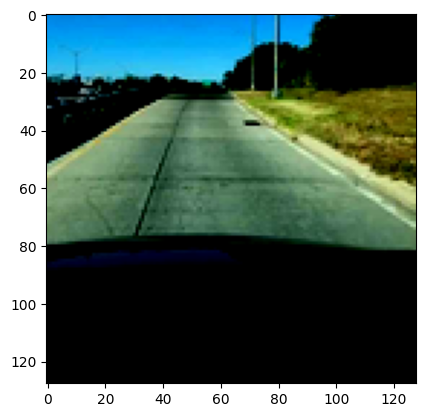

In [65]:
base_image = img_a.detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(base_image)

### Image generated by the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


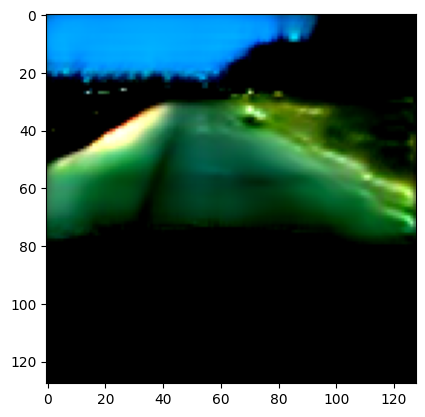

In [66]:
fake_image = fake_b.detach().cpu().numpy()[0].transpose(1, 2, 0)
plt.imshow(fake_image)